# Question 4

### MPPI Controller

References:

Model Predictive Control with Path Integral (MPPI) algorithm based on research paper "Model Predictive Path Integral Control using Covariance Variable Importance Sampling"

- Algorithm 1, page 6, in https://arxiv.org/pdf/1509.01149
- https://modernrobotics.northwestern.edu/nu-gm-book-resource/11-4-motion-control-with-torque-or-force-inputs-part-1-of-3/

Youtube tutorials:


In [127]:
import numpy as np
import matplotlib.pyplot as plt

In [128]:
class MPPIController:
    def __init__(self, num_sample, horizon_steps, step_time, sigma, lamb):
        self.numSamples = num_sample
        self.horizonSteps = horizon_steps
        self.stepTime = step_time
        # sigma determins the scale of control
        self.sigma = sigma
        # lambda determins weights of rollouts
        self.lamb = lamb

In [129]:
controller = MPPIController(100, 20, 0.1, 1.0, 0.1)
print(controller.horizonSteps)

20


### Dynamics of the Vehicle

In [130]:
def next_pos(x, y, control, step_time):
    # Get next pos with determined velocity
    x_next = x + control[0] * step_time
    y_next = y + control[1] * step_time
    return x_next, y_next

In [131]:
print(next_pos(0, 0, [2, 1], 3))
print(next_pos(1.2, 1.8, [0.1, 1.3], 0.5))
print(next_pos(-1.2, 1.8, [0.1, -1.3], 0.5))

(6, 3)
(1.25, 2.45)
(-1.15, 1.15)


### Cost

In [132]:
# Use a normal distribution for cost function
def random_samples(center, sigma, num_sample, horizon_steps):
    return np.random.normal(center, sigma, size=(num_sample, horizon_steps, 2))

In [133]:
# test to get 5 samples with 3 steps in horizon
print(random_samples(0, 1, 5, 3))

[[[-1.20845435  0.33821811]
  [ 0.37318847 -0.28308861]
  [-0.23579818  1.61011582]]

 [[-0.12594299 -0.91595966]
  [ 0.18305542 -0.56896896]
  [-0.50657926 -0.00537693]]

 [[-1.44093129  0.69599585]
  [ 1.09821924 -0.07854149]
  [ 1.42326701  1.24970835]]

 [[ 0.68757941  0.41985597]
  [-0.13720843 -0.75655833]
  [ 0.1622898   0.01051622]]

 [[ 0.05788147  1.6620618 ]
  [-1.1844093  -2.47659514]
  [ 0.8149691   1.34830369]]]


In [134]:
# Set target
TARGET_POSITION = [2, 3]

In [135]:
# define the cost function to be distance cost + control cost
def cost(x, y, ctrl, control_weight = 0.1):
    dist_cost = (x - TARGET_POSITION[0])**2 + (y - TARGET_POSITION[1])**2
    control_cost = ctrl[0]**2 + ctrl[1]**2
    return dist_cost + control_weight * control_cost

In [136]:
samples = random_samples(0, 1, 100, 5)
first_ctrl = samples[0, 0]
# test with different control weigths
for weight in [10, 1, 0.1, 0.01]:
    print("control_weight = ", weight, "cost = ", cost(1, 1, first_ctrl, weight))

control_weight =  10 cost =  32.01354700283589
control_weight =  1 cost =  7.70135470028359
control_weight =  0.1 cost =  5.270135470028359
control_weight =  0.01 cost =  5.027013547002836


In [137]:
def get_costs(controller, control_samples, x0, y0):

    # Rollout the trajectory of each sample
    costs = np.zeros(controller.numSamples)
    for i in range(controller.numSamples):
        x, y = x0, y0
        for j in range(controller.horizonSteps):
            ctrl = control_samples[i, j]
            x, y = next_pos(x, y, ctrl, controller.stepTime)
            costs[i] += cost(x, y, ctrl) * controller.stepTime

    return costs

In [138]:
# Testing
controller = MPPIController(10, 3, 0.1, 0.5, 0.1)
costs = get_costs(controller, samples, 0, 0)
print(costs)

[4.15844315 3.79489726 3.70108321 3.85994999 4.05564795 4.16108588
 3.70829363 4.14955969 4.2494636  3.81208818]


### Calculate Weights for Costs

In [139]:
import numpy as np

def calc_weights_from_costs(costs, lamb):
    weights = np.exp(-(costs) / lamb)
    weights /= np.sum(weights)
    return weights

In [140]:
# Try with lambda from 0.1 to 1.0
for l in range(1, 11):
    print(calc_weights_from_costs(costs, l*0.1))

[0.00353428 0.13401719 0.34244415 0.06992623 0.00987949 0.0034421
 0.31862167 0.00386261 0.00142234 0.11284993]
[0.02442993 0.15043609 0.24047318 0.10866553 0.04084502 0.02410924
 0.23195804 0.0255395  0.01549793 0.13804555]
[0.04258594 0.14307139 0.19559716 0.1151806  0.05998981 0.04221244
 0.19095208 0.04386583 0.03144131 0.13510344]
[0.05466922 0.13566188 0.17152015 0.11529958 0.07068892 0.05430922
 0.16845602 0.05589694 0.04354304 0.12995501]
[0.06283103 0.13000084 0.15683103 0.1141411  0.07717222 0.06249982
 0.15458562 0.06395732 0.05237389 0.12560713]
[0.06860615 0.12574952 0.14703178 0.11282871 0.08142705 0.06830464
 0.14527542 0.06962948 0.05894952 0.12219773]
[0.07287337 0.12249553 0.14006332 0.11162467 0.08440052 0.07259877
 0.13862799 0.07380407 0.0639879  0.11952387]
[0.07614162 0.1199443  0.13486779 0.11057693 0.08658175 0.07589051
 0.13365769 0.07699184 0.06795322 0.11739435]
[0.07871897 0.11789849 0.13085134 0.10967739 0.08824359 0.07848816
 0.1298072  0.07949981 0.07114

#### Compute Control

In [141]:
def compute_control(controller, x0, y0):

    # Generate random control samples centered at 0
    controlSamples = random_samples(0, controller.sigma, controller.numSamples, controller.horizonSteps)

    # Rollout the trajectory of each sample
    costs = get_costs(controller, controlSamples, x0, y0)

    # Calcuate weights for costs
    weights = calc_weights_from_costs(costs, controller.lamb)

    # Update control input with the first step in horizon
    ctrl_best = np.zeros(2)
    for j in range(controller.numSamples):
        ctrl_best += weights[j] * controlSamples[j, 0]

    return ctrl_best

In [142]:
print(compute_control(controller, 0, 0))

[0.46489373 0.17347311]


### Simulation

In [143]:
def run_simulation(controller, duration):

    x, y = 0, 0
    x_traj, y_traj = [0], [0]
    cx_traj, cy_traj = [0], [0]
    times = [0]

    total_steps = (int)(duration/controller.stepTime)

    for n in range(total_steps):
        control = compute_control(controller, x, y)
        cx_traj.append(control[0])
        cy_traj.append(control[1])
        x, y = next_pos(x, y, control, controller.stepTime)
        x_traj.append(x)
        y_traj.append(y)
        times.append((n+1) * controller.stepTime)

    return x_traj, y_traj, cx_traj, cy_traj, times

In [144]:
controller = MPPIController(10, 3, 1, 0.5, 0.5)
for _ in range(5):
    print("Run:")
    X, Y, CX, CY, times = run_simulation(controller, 5)
    print("times = ", times)
    print("x_traj = ", X)
    print("y_traj = ", Y)
    print("cx_traj = ", CX)
    print("cy_traj = ", CY)

Run:
times =  [0, 1, 2, 3, 4, 5]
x_traj =  [0, np.float64(0.35348643973189986), np.float64(1.2879662204114062), np.float64(1.6566952632129548), np.float64(2.475379797778706), np.float64(2.2592248663698262)]
y_traj =  [0, np.float64(0.8678131203683641), np.float64(1.7798092963222505), np.float64(1.8793481906957061), np.float64(2.492682089100735), np.float64(2.8833262040112837)]
cx_traj =  [0, np.float64(0.35348643973189986), np.float64(0.9344797806795063), np.float64(0.36872904280154856), np.float64(0.8186845345657511), np.float64(-0.21615493140887976)]
cy_traj =  [0, np.float64(0.8678131203683641), np.float64(0.9119961759538864), np.float64(0.09953889437345566), np.float64(0.6133338984050287), np.float64(0.3906441149105484)]
Run:
times =  [0, 1, 2, 3, 4, 5]
x_traj =  [0, np.float64(0.19785201678567058), np.float64(0.9087343288485392), np.float64(1.5216470661680388), np.float64(2.0830473057688756), np.float64(2.557664335113002)]
y_traj =  [0, np.float64(0.26576342546524007), np.float64(

### Plot

In [145]:
def plot_traj(x_traj: list, y_traj: list, cx_traj: list, cy_traj: list, times: list, filename: str = "positions.png"):
    plt.figure(figsize=(10, 5))

    plt.subplot(2, 2, 1)
    plt.plot(times, x_traj)
    plt.axhline(y=TARGET_POSITION[0], color='r', linestyle='--', label='Setpoint')
    plt.xlabel('Time (s)')
    plt.ylabel('X Position')
    plt.title('X Position vs. Time')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(times, y_traj)
    plt.axhline(y=TARGET_POSITION[1], color='r', linestyle='--', label='Setpoint')
    plt.xlabel('Time (s)')
    plt.ylabel('Y Position')
    plt.title('Y Position vs. Time')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(times, cx_traj)
    plt.xlabel('Time (s)')
    plt.ylabel('Control X')
    plt.title('Control X vs. Time')
    
    plt.subplot(2, 2, 4)
    plt.plot(times, cy_traj)
    plt.xlabel('Time (s)')
    plt.ylabel('Control Y')
    plt.title('Control Y vs. Time')
    
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

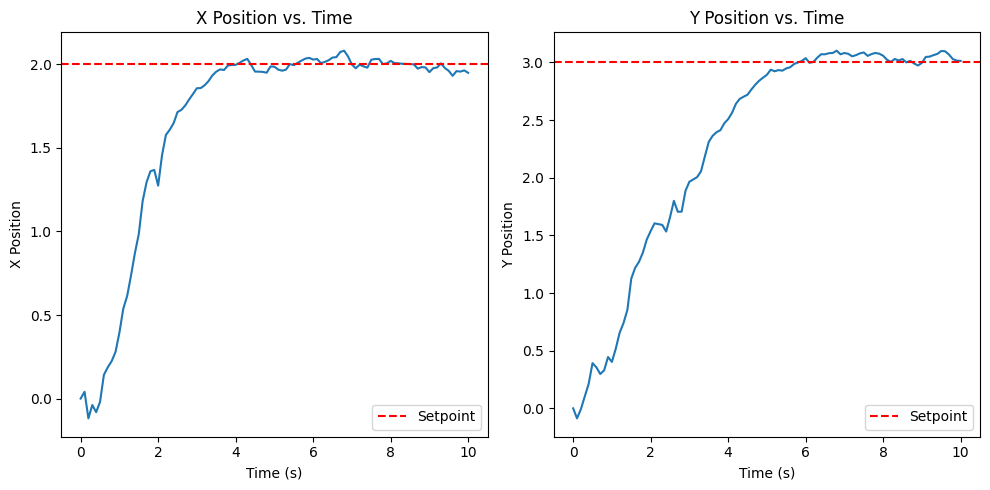

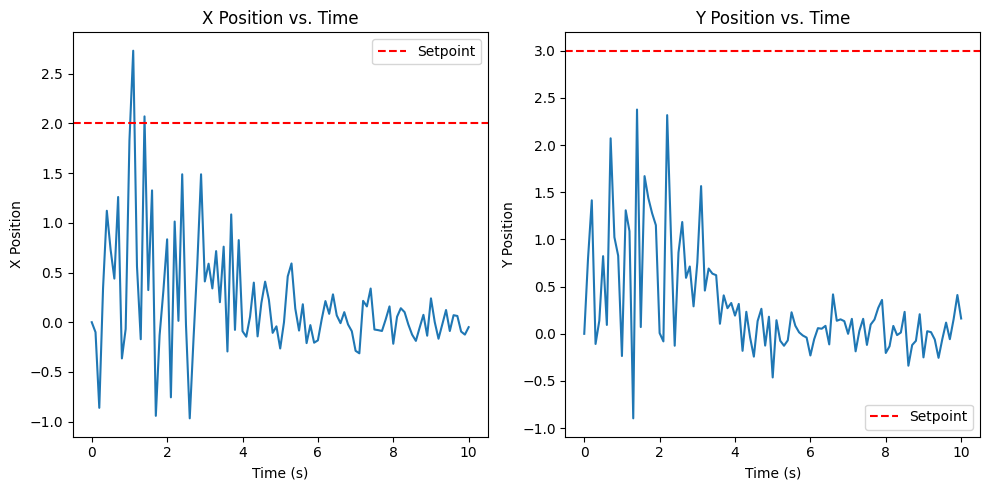

In [146]:
# Test Run 1
controller = MPPIController(100, 20, 0.1, 1.0, 0.1)
plot_traj(*run_simulation(controller, 10))

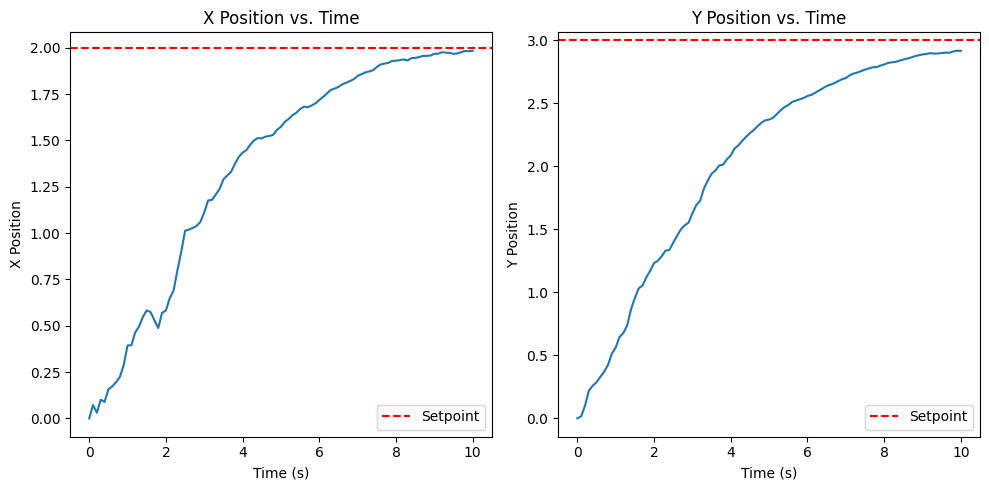

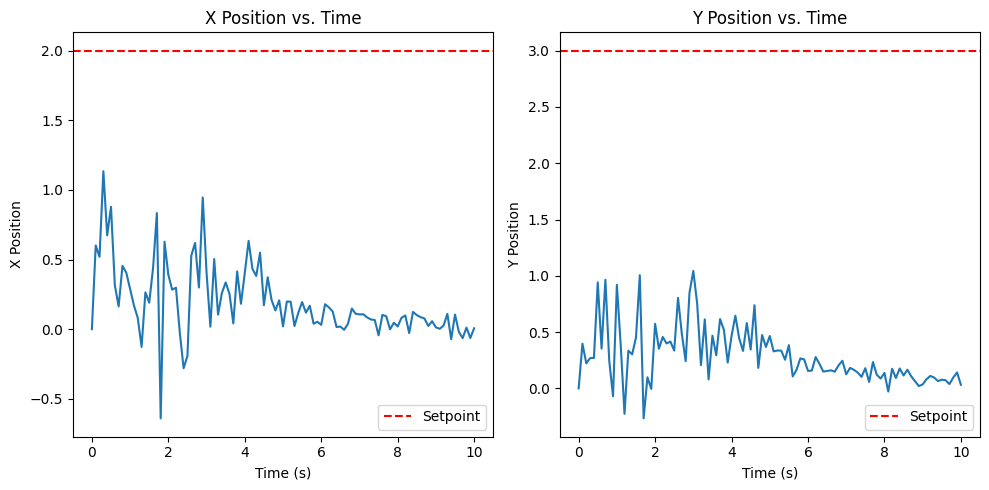

In [147]:
# Test Run slower control velocity in 10 secs
controller = MPPIController(100, 10, 0.1, 0.5, 0.1)
plot_traj(*run_simulation(controller, 10))

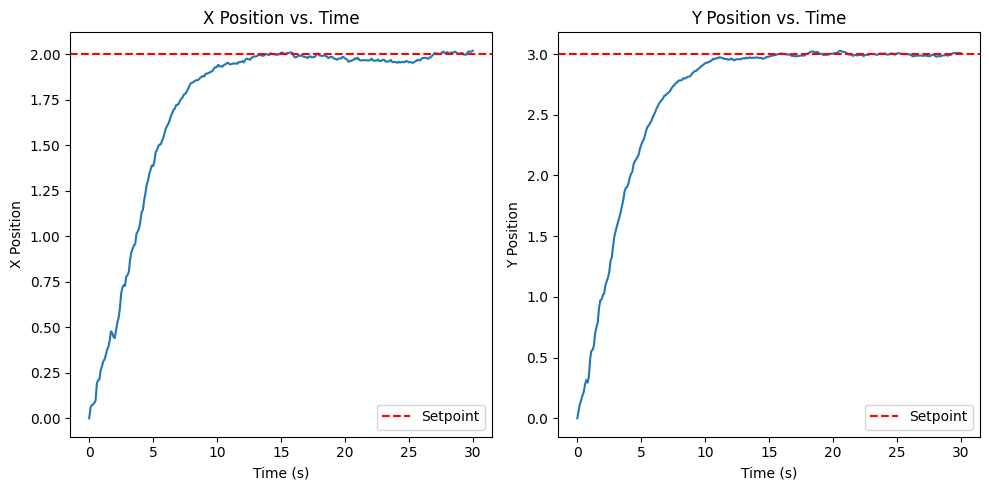

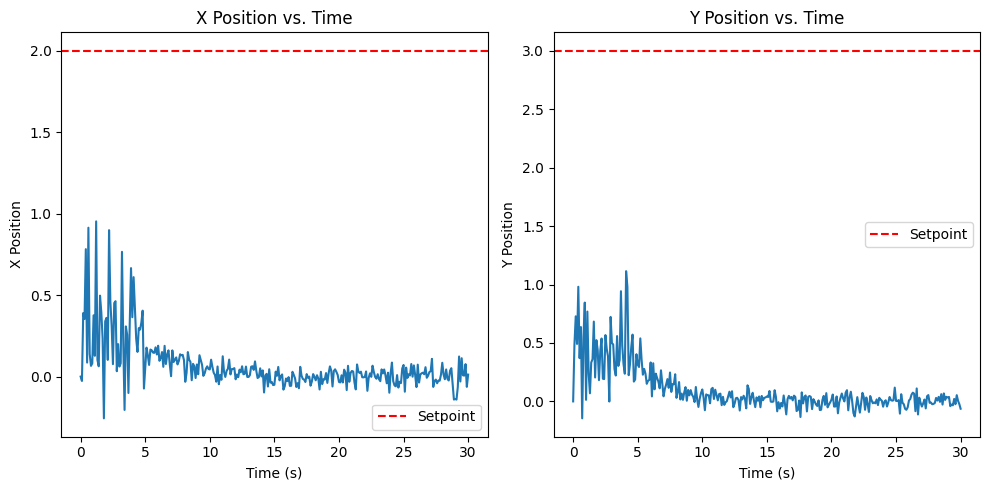

In [148]:
# Test Run with 30 secs
controller = MPPIController(100, 10, 0.1, 0.5, 0.1)
plot_traj(*run_simulation(controller, 30))